In [2]:
import importlib
import MPI_collective
import MPI
import qiskit
import math
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
importlib.reload(MPI_collective)
importlib.reload(MPI)

<module 'MPI' from '/workspaces/qmpi_cpe_kmutt/QMPI_Tinthai_Version/playground/MPI.py'>

In [3]:
# Requirement
# !pip install qiskit
# !pip install pylatexenc
# !pip install qiskit-aer
# !pip install supermarq

In [4]:
# Function พวกนี้ เราเขียนมาเพื่อให้ใช้งานง่ายขึ้นเฉยๆนะ

def qdata_to_circuit(qc, qdata):
    # for inst, qargs, cargs in qdata:
    #     qc.append(inst, qargs, cargs)
    for instr in qdata:
        qc.append(instr.operation, instr.qubits, instr.clbits)

def beautifule_print_result(qc, counts):
    creg_sequence = []
    for creg in qc.cregs:
        creg_sequence.append(f"{creg.name}[{creg.size}]")
    creg_sequence.reverse()
    print("Classical registers (left→right):", " → ".join(creg_sequence))

    print("\nCounts:")
    for bits, count in counts.items():
        print(f"{bits} : {count}")

def prob_single_cbit(counts, target_index):
    # index ของ cbit ตรงกลาง (จากซ้ายไปขวา)
    total = sum(counts.values())

    p0 = sum(v for k, v in counts.items() if k.split()[target_index] == '0') / total
    p1 = sum(v for k, v in counts.items() if k.split()[target_index] == '1') / total

    print(f"P(cbit[{target_index}] = 0) = {p0:.4f}")
    print(f"P(cbit[{target_index}] = 1) = {p1:.4f}")

In [5]:
# สร้าง Quantum circuit โดยเตรียมพวก Quantum register,  Classical register เอาไว้ใช้
sendqc_circuit = QuantumCircuit()
node1 = QuantumRegister(1, name = "node1")
node1_epr = QuantumRegister(2, name = "node1_epr")
node1_epr_creg = ClassicalRegister(1, name = "node1_epr_creg")
node2 = QuantumRegister(1, name = "node2")
node2_epr = QuantumRegister(2, name = "node2_epr")
node2_epr_creg = ClassicalRegister(1, name = "node2_epr_creg")
node3 = QuantumRegister(1, name = "node3")
node3_epr = QuantumRegister(1, name = "node3_epr")
node3_epr_creg = ClassicalRegister(1, name = "node3_epr_creg")
epr_c = ClassicalRegister(2, name = "epr_cr")
sendqc_circuit.add_register(node1,node1_epr,node2,node2_epr,node3,node3_epr)
sendqc_circuit.add_register(node1_epr_creg,node2_epr_creg,node3_epr_creg)
# sendqc_circuit.draw('mpl')

In [6]:
# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
sendqc_circuit.rx(math.pi/4, node1[0])   # หมุนแกน X มุม π/4 บน qubit 0
# ลองใช้ QMPI ของ Tom Nguyen ดู
sendqc_epr_class = MPI.EPRsetup(sendqc_circuit, node1[0], node2[0])

# Send 
operation = sendqc_epr_class.send()
qdata_to_circuit(sendqc_epr_class.q, operation)

# # Unsend
# operation = sendqc_epr_class.unsend()
# qdata_to_circuit(sendqc_epr_class.q, operation)

# การวัดด้วยตัวเอง
sendqc_epr_class.q.barrier()
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node1_epr[0], node1_epr_creg[0])
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node2_epr[0], node2_epr_creg[0])
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node3_epr[0], node3_epr_creg[0])

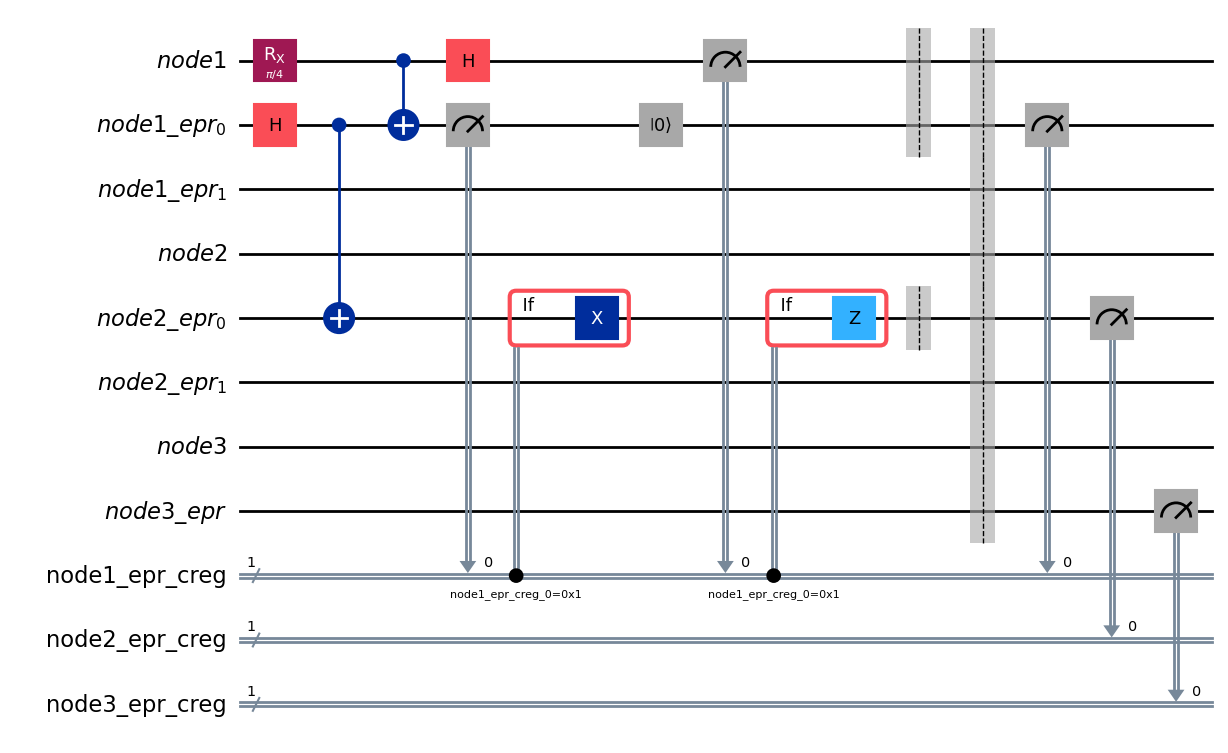

In [7]:
# # เผื่ออยากดูวงจร
sendqc_epr_class.q.draw('mpl')

In [8]:
sim = AerSimulator()
sendqc_ready2run = transpile(sendqc_epr_class.q, sim)
result = sim.run(sendqc_ready2run).result()
counts = result.get_counts()
beautifule_print_result(sendqc_epr_class.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

prob_single_cbit(counts, target_index=1)

Classical registers (left→right): node3_epr_creg[1] → node2_epr_creg[1] → node1_epr_creg[1]

Counts:
0 1 0 : 148
0 0 0 : 876
P(cbit[1] = 0) = 0.8555
P(cbit[1] = 1) = 0.1445


In [9]:
# # build distributed circuit with N nodes and returns circuit with list of quantum registers
# def buildQMPI(N):
#     circ = QuantumCircuit() 
#     qrs = [] 
#     for i in range(N):
#         qr = QuantumRegister(1, name = 'q'+str(i))
#         circ.add_register(qr)
#         qrs.append(qr)
#     cr = ClassicalRegister(N,name = 'cr')
#     circ.add_register(cr)
#     return circ, qrs

# a,b = buildQMPI(4)

# This section is Collective Operation parts

In [10]:
for i in range(5):
    print(f"Smile{i}")

Smile0
Smile1
Smile2
Smile3
Smile4


In [11]:
collective_circuit = QuantumCircuit()
nodes_count = 4
qnode = {}
for i in range(nodes_count):
    qnode[i] = QuantumRegister(1, name = f"node{i}")
    collective_circuit.add_register(qnode[i])

In [12]:
# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
collective_circuit.rx(math.pi/4, qnode[0][0])   # หมุนแกน X มุม π/4 บน qubit 0

collective_class = MPI_collective.CollectiveMPI(collective_circuit)
# collective_class.q.draw('mpl')
# print(collective_class.length)

# Broadcast 
operation = collective_class.brodcast([qnode[0][0], qnode[1][0], qnode[2][0], qnode[3][0]])

# qdata_to_circuit(collective_class.q, operation)

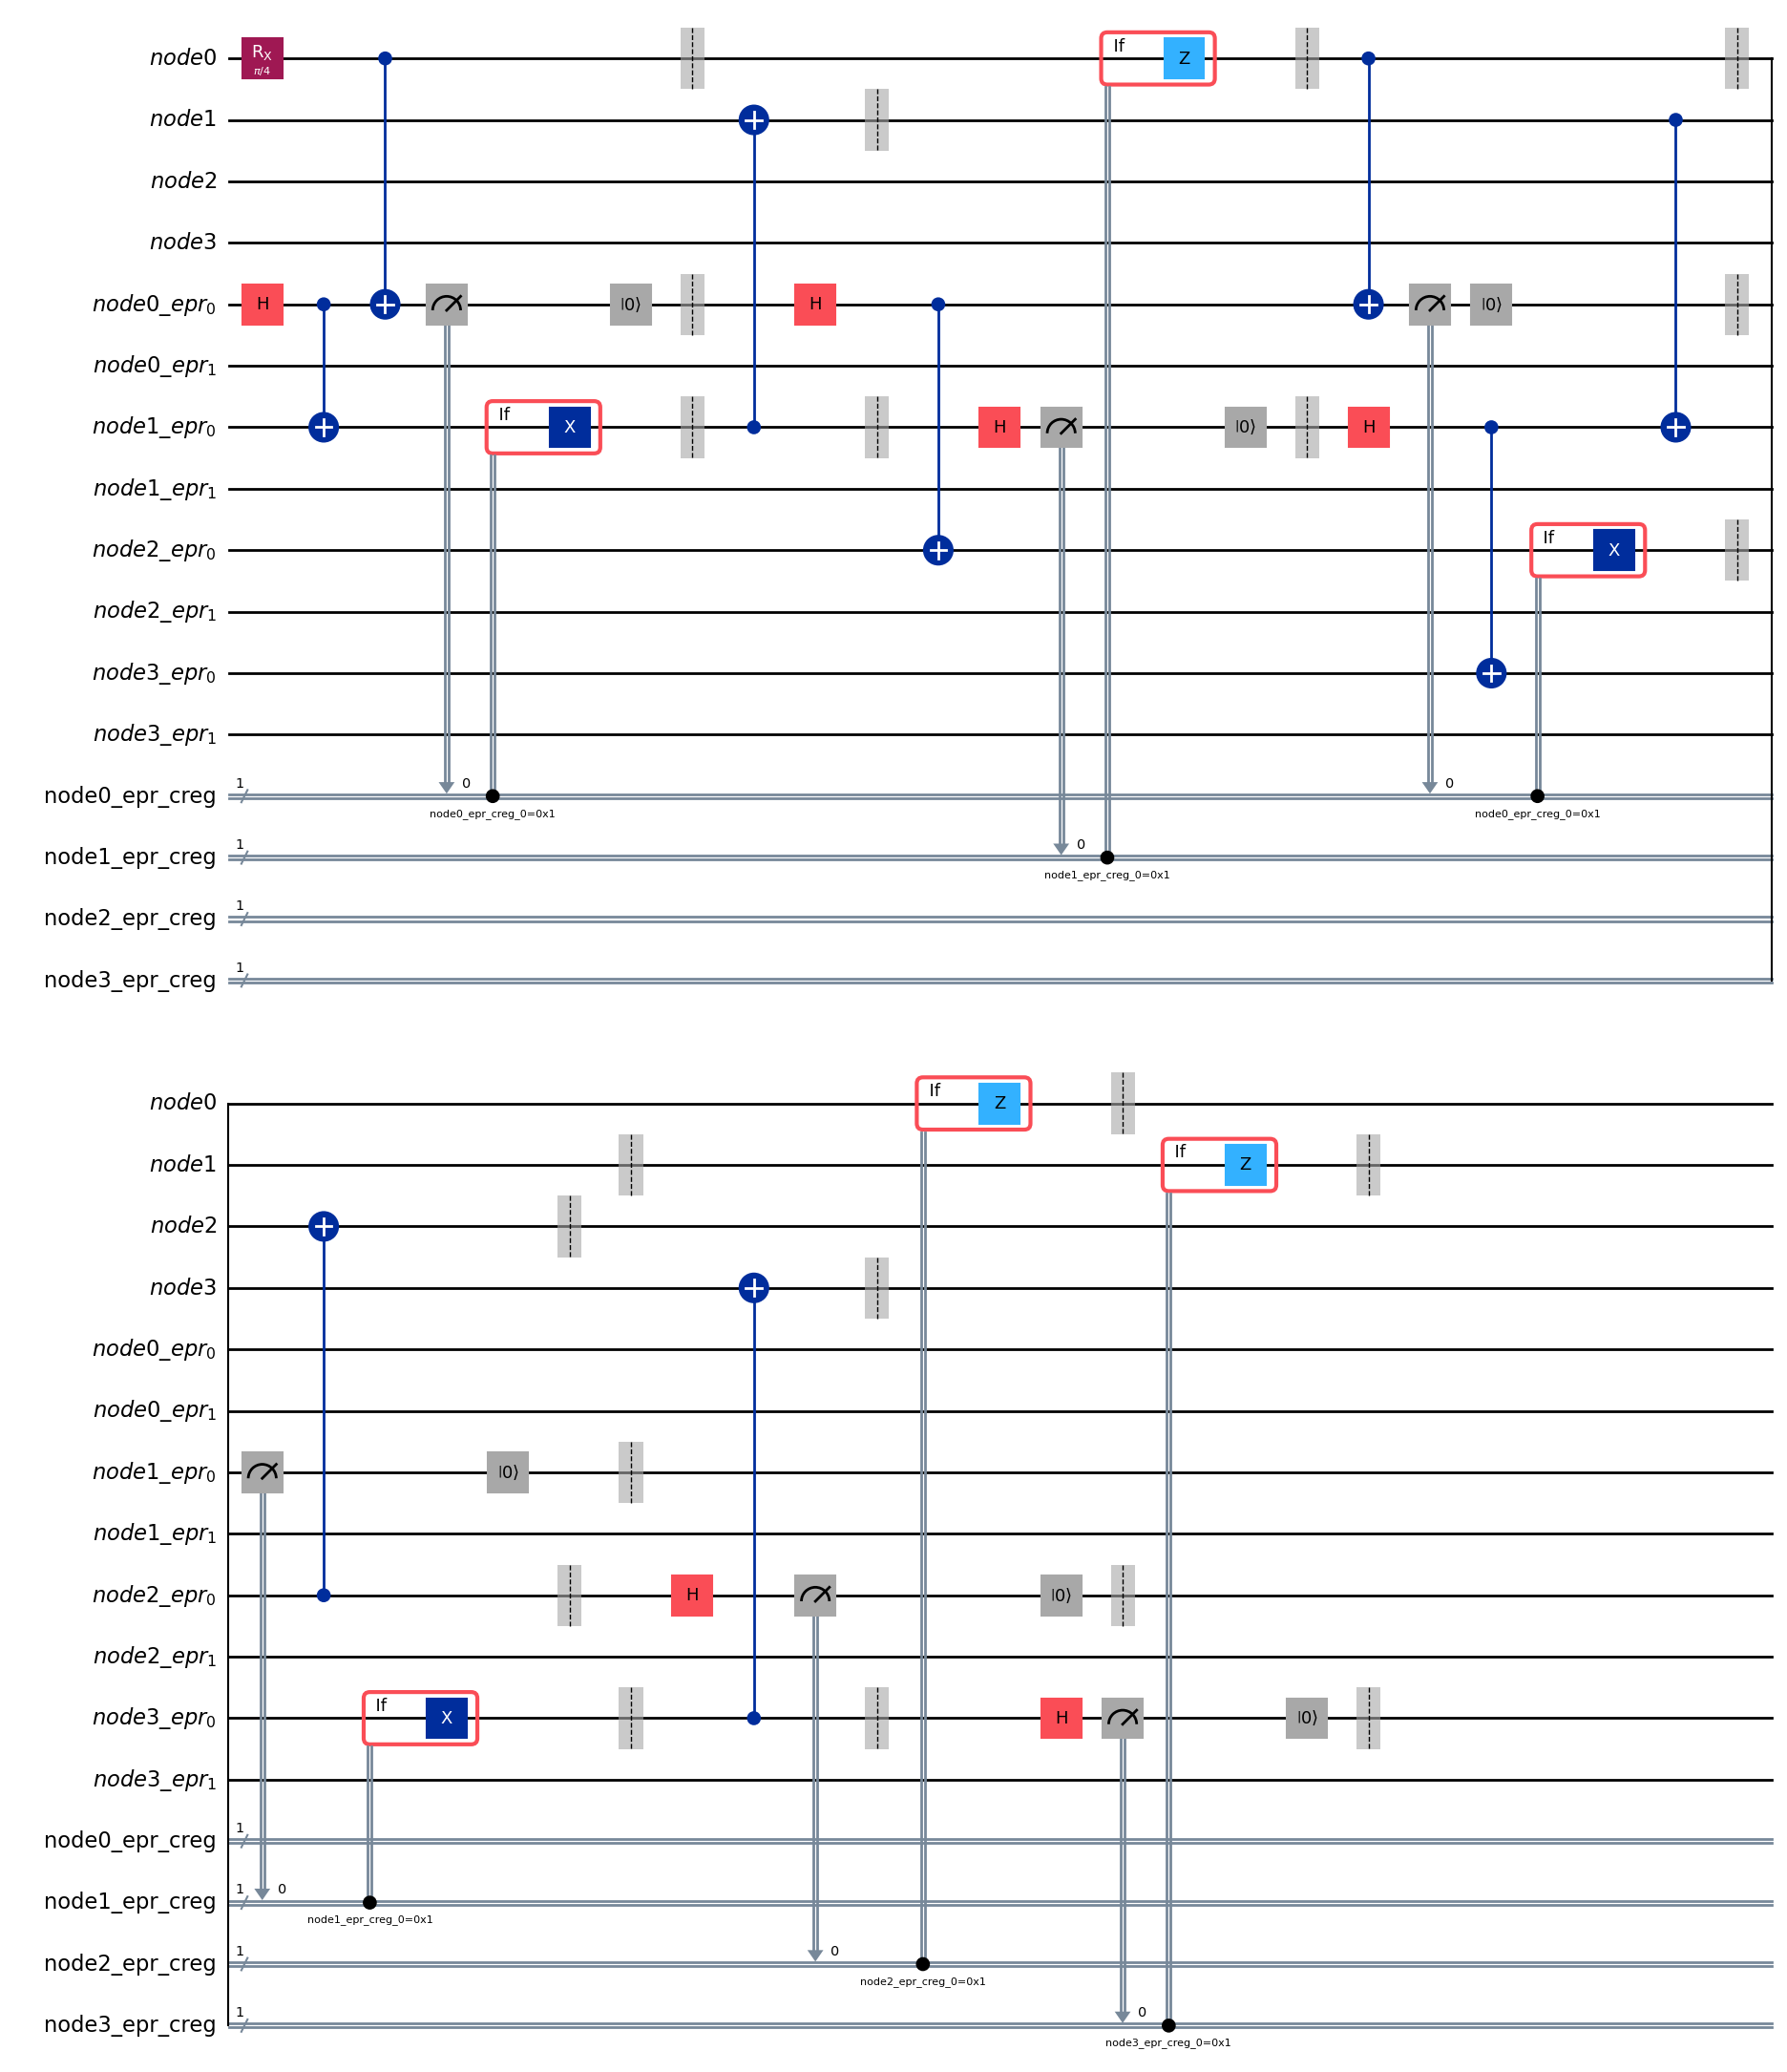

In [13]:
collective_class.q.draw('mpl')

In [14]:
sim = AerSimulator()
collective_ready2run = transpile(collective_class.q, sim)
result = sim.run(collective_ready2run).result()
counts = result.get_counts()
beautifule_print_result(collective_class.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

prob_single_cbit(counts, target_index=0)

Classical registers (left→right): node3_epr_creg[1] → node2_epr_creg[1] → node1_epr_creg[1] → node0_epr_creg[1]

Counts:
1 0 1 0 : 70
1 1 0 0 : 87
0 1 1 0 : 65
1 0 0 0 : 75
0 0 1 0 : 63
0 0 0 0 : 68
1 0 0 1 : 64
0 1 0 1 : 74
1 1 1 0 : 65
1 1 0 1 : 65
1 1 1 1 : 51
0 0 0 1 : 61
1 0 1 1 : 48
0 1 1 1 : 60
0 0 1 1 : 50
0 1 0 0 : 58
P(cbit[0] = 0) = 0.4873
P(cbit[0] = 1) = 0.5127


In [82]:
def my_qtp(qq, src, eprsrc, dsc, srccreg):
    qq.q.cx(src, eprsrc)
    qq.recieveEPR(qq.q, eprsrc, srccreg)
    with qq.q.if_test((srccreg,1)):
        qq.q.x(dsc)
    qq.q.h(src)
    qq.recieveEPR(qq.q, src, srccreg)
    with qq.q.if_test((srccreg,1)):
        qq.q.z(dsc)

    qq.q.reset(eprsrc)
    qq.q.barrier()
    return qq

# def my_bcast(qq, bcast_arr):
#     node_original = bcast_arr[0]
#     qq.q.cx(bcast_buffer[0], bcast_arr[1])

In [83]:
collective_circuit_tinthai = QuantumCircuit()
node0 = QuantumRegister(1, name = "node0")
node0_epr = QuantumRegister(2, name = "node0_epr")
node0_epr_creg = ClassicalRegister(1, name = "node0_epr_creg")

bcast_buffer = QuantumRegister(1, name = "bcast_buffer")
bcast_buffer_epr = QuantumRegister(2, name = "bcast_buffer_epr")
bcast_buffer_epr_creg = ClassicalRegister(1, name = "bcast_buffer_epr_creg")
bcast_device = QuantumRegister(3, name = "bcast_device")
bcast_device_epr = QuantumRegister(3, name = "bcast_device_epr")
bcast_device_epr_creg = ClassicalRegister(3, name = "bcast_device_epr_creg")

node1 = QuantumRegister(1, name = "node1")
node1_epr = QuantumRegister(2, name = "node1_epr")
node1_epr_creg = ClassicalRegister(1, name = "node1_epr_creg")
node2 = QuantumRegister(1, name = "node2")
node2_epr = QuantumRegister(2, name = "node2_epr")
node2_epr_creg = ClassicalRegister(1, name = "node2_epr_creg")
node3 = QuantumRegister(1, name = "node3")
node3_epr = QuantumRegister(2, name = "node3_epr")
node3_epr_creg = ClassicalRegister(1, name = "node3_epr_creg")
node4 = QuantumRegister(1, name = "node4")
node4_epr = QuantumRegister(2, name = "node4_epr")
node4_epr_creg = ClassicalRegister(1, name = "node4_epr_creg")

collective_circuit_tinthai.add_register(node0, node0_epr, bcast_buffer, bcast_buffer_epr, bcast_device, bcast_device_epr, node1, node1_epr, node2, node2_epr, node3, node3_epr)
collective_circuit_tinthai.add_register(node0_epr_creg, bcast_buffer_epr_creg, bcast_device_epr_creg, node1_epr_creg, node2_epr_creg, node3_epr_creg)

# Initiate ให้ node1[0] มีโอกาส ket(0) ~75%
collective_circuit_tinthai.rx(math.pi/4, node0[0])   # หมุนแกน X มุม π/4 บน qubit 0
collective_circuit_tinthai.ry(math.pi/4, node0[0])   # หมุนแกน Y มุม π/4 บน qubit 0

# ลองใช้ QMPI ของ Tom Nguyen ดู
collective_circuit_tinthai = MPI.EPRsetup(collective_circuit_tinthai, node0[0], bcast_buffer[0])

# Init bcast device
collective_circuit_tinthai.q.h(bcast_device_epr[0])
collective_circuit_tinthai.q.h(bcast_device_epr[1])
collective_circuit_tinthai.q.h(bcast_device_epr[2])
collective_circuit_tinthai.q.cx(bcast_device_epr[0], node1[0])
collective_circuit_tinthai.q.cx(bcast_device_epr[1], node2[0])
collective_circuit_tinthai.q.cx(bcast_device_epr[2], node3[0])

# Send to buffer
operation = collective_circuit_tinthai.send()
qdata_to_circuit(collective_circuit_tinthai.q, operation)
collective_circuit_tinthai.q.cx(bcast_buffer_epr[0], bcast_buffer[0])

# Device setup
collective_circuit_tinthai.q.barrier()
collective_circuit_tinthai.q.cx(bcast_buffer[0], bcast_device[0])
collective_circuit_tinthai.q.cx(bcast_device[0], bcast_device[1])
collective_circuit_tinthai.q.cx(bcast_device[1], bcast_device[2])

# Bcast
collective_circuit_tinthai.q.barrier()
collective_circuit_tinthai = my_qtp(collective_circuit_tinthai, bcast_device[0], bcast_device_epr[0], node1[0], bcast_device_epr_creg[0])
collective_circuit_tinthai = my_qtp(collective_circuit_tinthai, bcast_device[1], bcast_device_epr[1], node2[0], bcast_device_epr_creg[1])
collective_circuit_tinthai = my_qtp(collective_circuit_tinthai, bcast_device[2], bcast_device_epr[2], node3[0], bcast_device_epr_creg[2])

# # UnBroadcast
# collective_circuit_tinthai.q.barrier()
# collective_circuit_tinthai.q.barrier()
# collective_circuit_tinthai.q.reset(node3_epr[0])
# collective_circuit_tinthai.q.reset(node0[0])
# collective_circuit_tinthai.q.reset(bcast_buffer[0])
# collective_circuit_tinthai.q.barrier()
# collective_circuit_tinthai = my_qtp(collective_circuit_tinthai, node3[0], node3_epr[0], bcast_buffer[0], node3_epr_creg[0])
# collective_circuit_tinthai.q.cx(bcast_buffer[0], node0[0])
# # operation = collective_circuit_tinthai.unsend()
# # qdata_to_circuit(collective_circuit_tinthai.q, operation)

# การวัดด้วยตัวเอง
collective_circuit_tinthai.q.barrier()

# ทดสอบว่ามี node 0 entanglement กับอะไร ไหม
# collective_circuit_tinthai.q.reset(node1[0])
# collective_circuit_tinthai.q.reset(node2[0])
# collective_circuit_tinthai.q.reset(node3[0])

collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node0[0], node0_epr_creg[0])
collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node1[0], node1_epr_creg[0])
collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node2[0], node2_epr_creg[0])
collective_circuit_tinthai.recieveEPR(collective_circuit_tinthai.q, node3[0], node3_epr_creg[0])

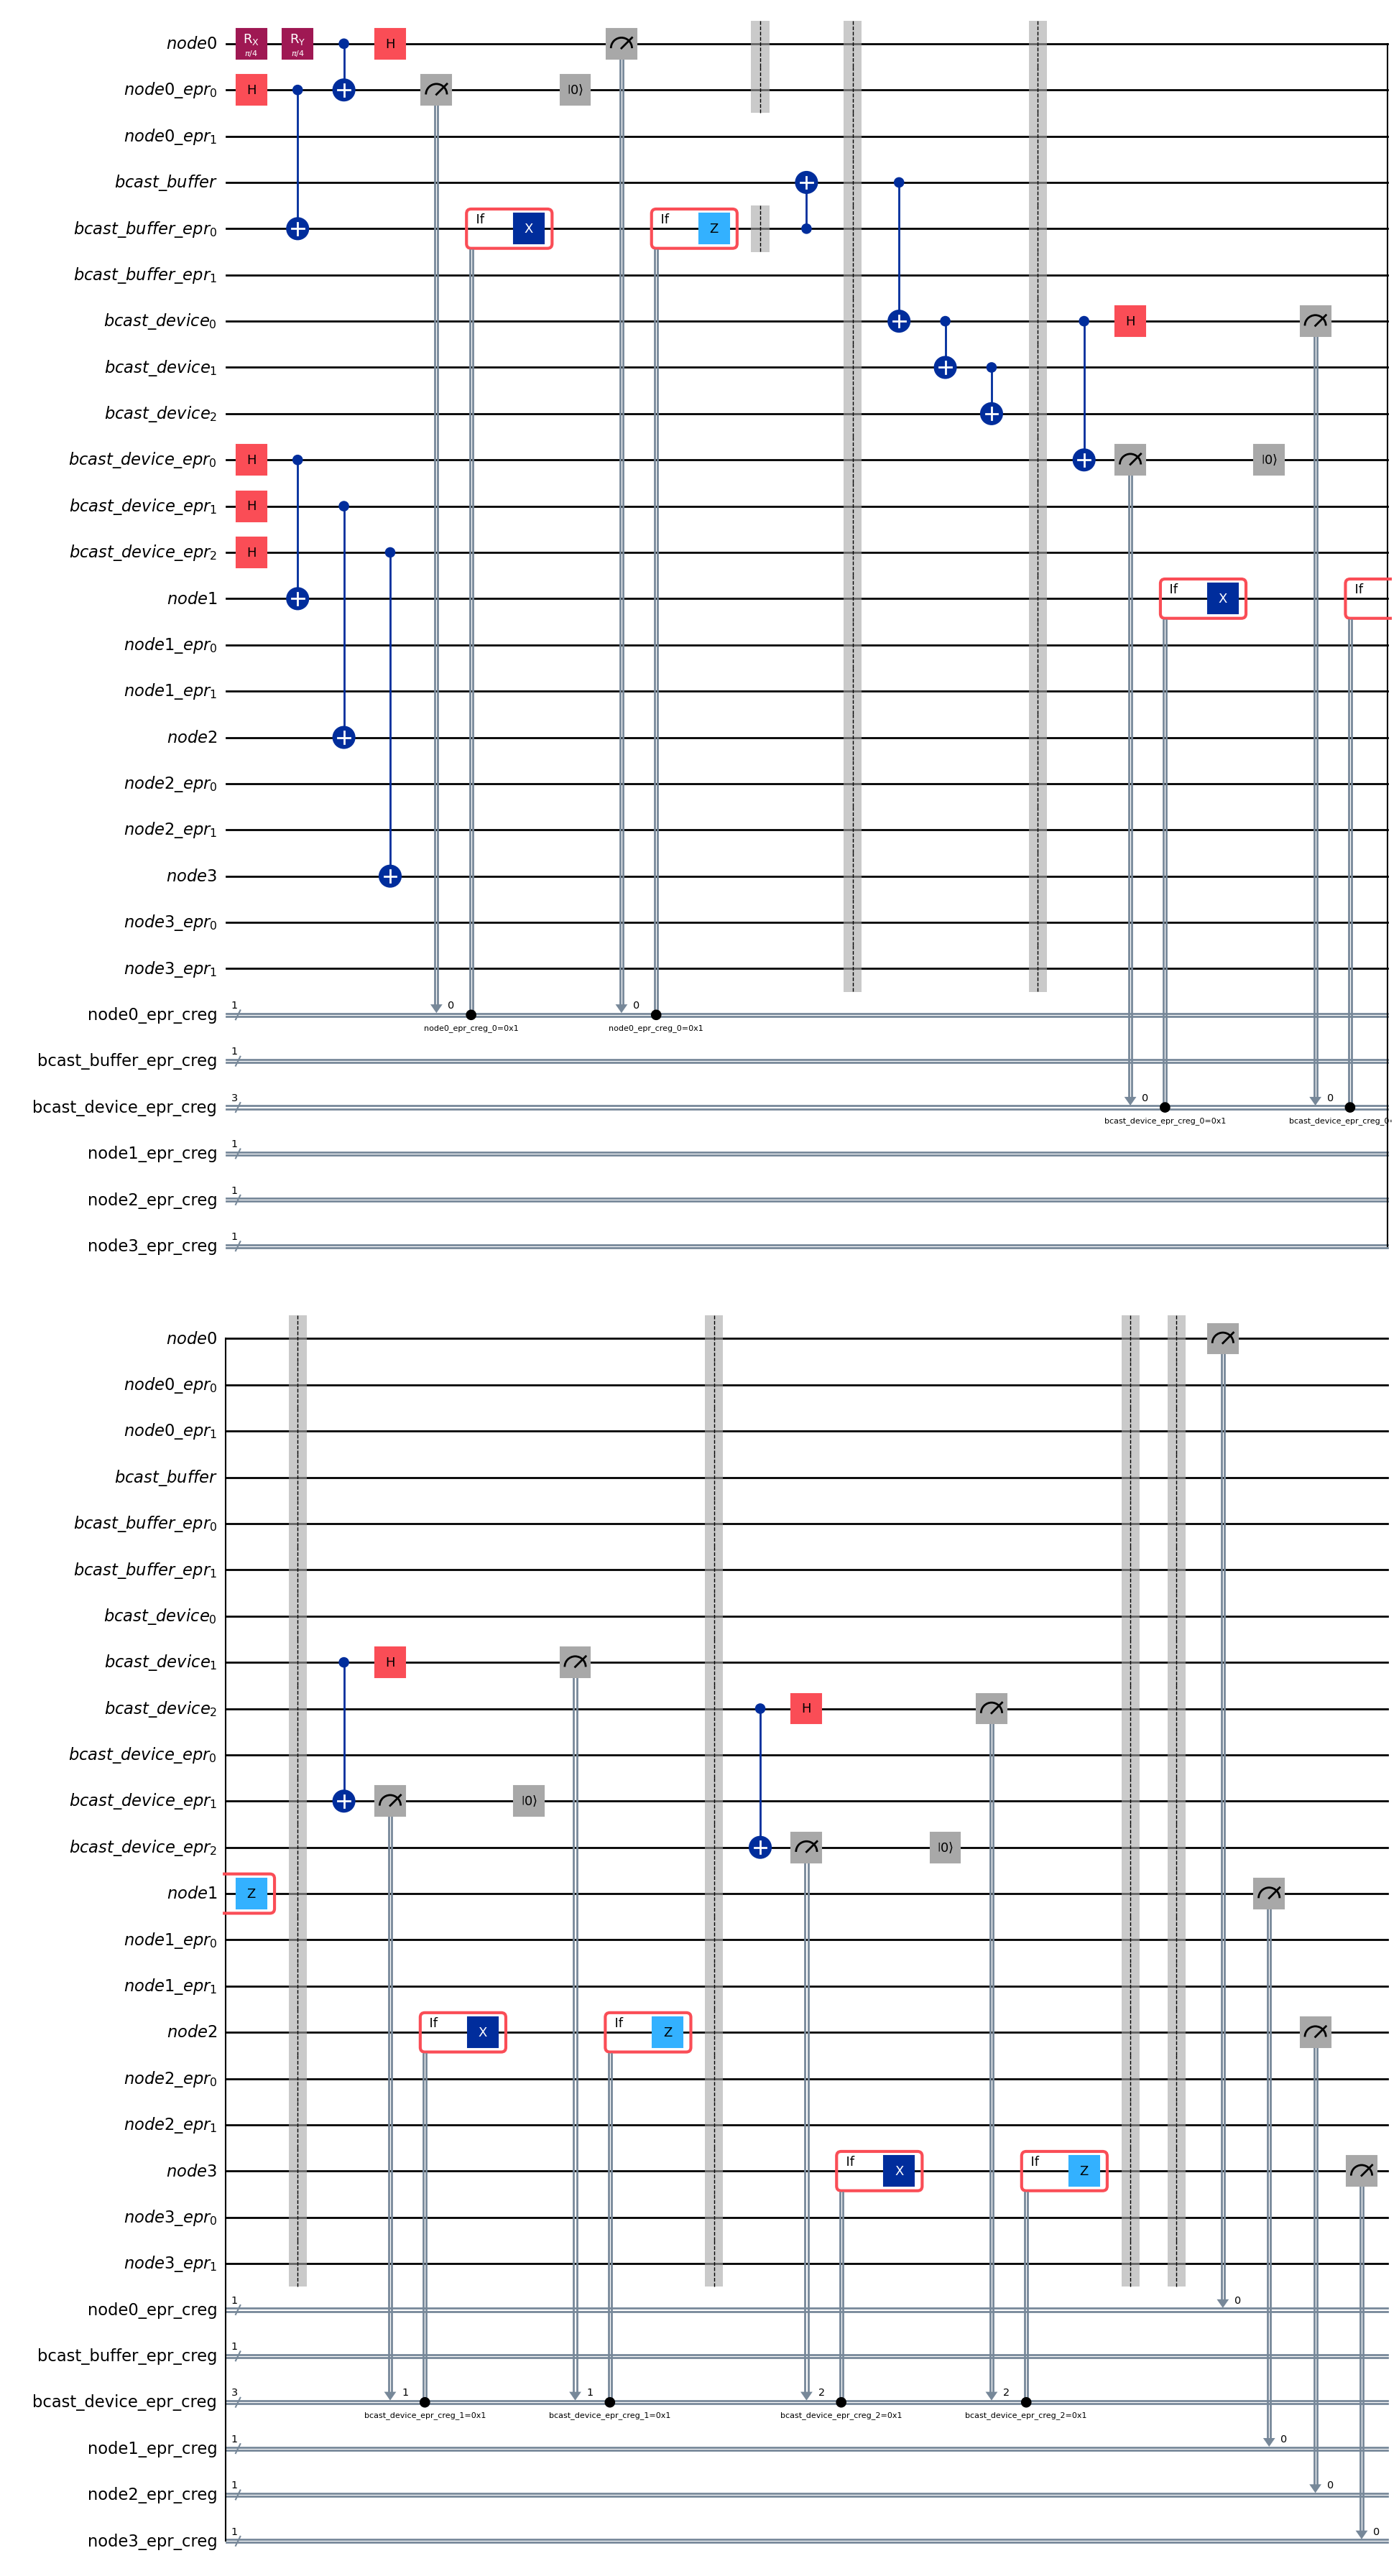

In [84]:
collective_circuit_tinthai.q.draw("mpl")

In [85]:
sim = AerSimulator()
collective_circuit_tinthai_ready2rn = transpile(collective_circuit_tinthai.q, sim)
result = sim.run(collective_circuit_tinthai_ready2rn).result()
counts = result.get_counts()
# beautifule_print_result(collective_circuit_tinthai.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

print("Node 0 Prob:")
prob_single_cbit(counts, target_index=5)
print("")

print("Node 1 Prob:")
prob_single_cbit(counts, target_index=2)
print("")

print("Node 2 Prob:")
prob_single_cbit(counts, target_index=1)
print("")

print("Node 3 Prob:")
prob_single_cbit(counts, target_index=0)
print("")

Node 0 Prob:
P(cbit[5] = 0) = 0.5107
P(cbit[5] = 1) = 0.4893

Node 1 Prob:
P(cbit[2] = 0) = 0.7598
P(cbit[2] = 1) = 0.2402

Node 2 Prob:
P(cbit[1] = 0) = 0.7598
P(cbit[1] = 1) = 0.2402

Node 3 Prob:
P(cbit[0] = 0) = 0.7598
P(cbit[0] = 1) = 0.2402



In [86]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# 1️⃣ ลบการวัดออก (เพื่อดูสถานะก่อน collapse)
circ_no_measure = collective_circuit_tinthai.q.remove_final_measurements(inplace=False)

# 2️⃣ บอกให้ simulator เก็บ statevector
circ_no_measure.save_statevector() 

# 3️⃣ ใช้ simulator แบบ statevector
sim_sv = AerSimulator(method='statevector')

# 4️⃣ transpile และรัน
ready_sv = transpile(circ_no_measure, sim_sv)
result_sv = sim_sv.run(ready_sv).result()

# 5️⃣ ดึงข้อมูล statevector ออกมา
statevector = result_sv.data(0)['statevector']
# print(statevector)

In [89]:
from qiskit.quantum_info import Statevector
import numpy as np

# statevector จากผล simulation
vec = Statevector(statevector)

# แสดงเฉพาะค่าสำคัญ
for i, amp in enumerate(vec.data):
    if not np.isclose(abs(amp), 0):  # ข้ามค่าที่แทบเป็นศูนย์
        print(f"|{i:0{vec.num_qubits}b}> : {amp}")


|000000000000000000000> : (0.6035533905932741+0.10355339059327384j)
|000000000000100000000> : (0.603553390593274+0.10355339059327383j)
|001001001000000011000> : (0.2499999999999997-0.24999999999999986j)
|001001001000100011000> : (-0.24999999999999975+0.2499999999999999j)
|001001001000000011000> : (0.2499999999999997-0.24999999999999986j)
|001001001000100011000> : (-0.24999999999999975+0.2499999999999999j)


In [87]:
import pickle

with open('/workspaces/qmpi_cpe_kmutt/QMPI_Tinthai_Version/playground/vec1.plk', 'wb') as f:
    pickle.dump(vec, f)

In [88]:
import pickle

with open('/workspaces/qmpi_cpe_kmutt/QMPI_Tinthai_Version/playground/vec1.plk', 'rb') as f:
    vec = pickle.load(f)

In [ ]:
(0.125**2 + 0.12500000000000014**2)*8

0.2500000000000003

In [ ]:
#Original
# [ 0.854+0.146j, 0.354-0.354j ] #0, 1

# [ 0.302+0.052j, 0.302+0.052j, 0.302+0.052j, 0.302+0.052j, #0
#  0.125-0.125j, 0.125-0.125j, 0.125-0.125j, 0.125-0.125j, #1
#  0.302+0.052j, 0.302+0.052j, 0.302+0.052j, 0.302+0.052j,  #0
#  0.125-0.125j, 0.125-0.125j, 0.125-0.125j, 0.125-0.125j ] #1

In [ ]:
# |000000000000110000000> : (0.7071067811865476+0j)
# |001000000000110000000> : (0.7071067811865475+0j)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


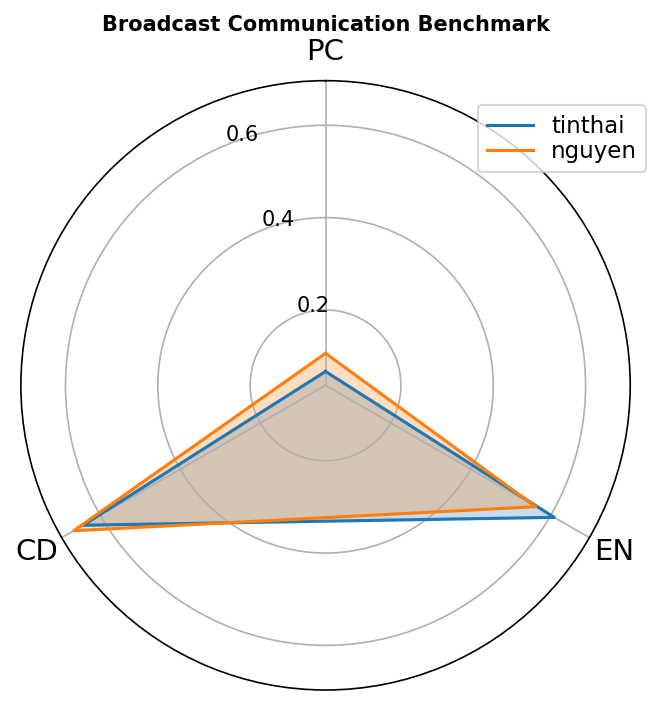

In [ ]:
from supermarq import *

bcast_tinthai = [
  converters.compute_communication_with_qiskit(collective_circuit_tinthai_ready2rn),
  converters.compute_depth_with_qiskit(collective_circuit_tinthai_ready2rn),
  converters.compute_entanglement_with_qiskit(collective_circuit_tinthai_ready2rn),
]

bcast_nguyen = [
  converters.compute_communication_with_qiskit(collective_ready2run),
  converters.compute_depth_with_qiskit(collective_ready2run),
  converters.compute_entanglement_with_qiskit(collective_ready2run),
]

spoke_labels = ["PC", "CD", "EN"]
plotting.plot_benchmark(
    title= "Broadcast Communication Benchmark",
    labels=["tinthai", "nguyen"],             # one label
    features=[bcast_tinthai, bcast_nguyen],        # must be a list of feature lists
    spoke_labels=spoke_labels,
    show=True
)